<a href="https://colab.research.google.com/github/quinyang/svhn_dl/blob/yassine/notebooks/cnn_y.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Dependnecies and setting up**
   - Make sure you read comments to know which ones to run

In [1]:
## run only in colab after cloning repo to be able to access other files easily
import sys
import os
GIT_PATH = '/content/svhn_dl'
CODE_PATH = '/content/svhn_dl/src'

if GIT_PATH not in sys.path:
  sys.path.append(GIT_PATH)

if CODE_PATH not in sys.path:
    sys.path.append(CODE_PATH)


In [2]:
# DO NOT RUN THIS CELL IF RUNNING LOCALLY
# run to install dependencide IN COLAB if running locally use next cell
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
!pip install numpy matplotlib scipy scikit-learn jupyter

Looking in indexes: https://download.pytorch.org/whl/cu121
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 128.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.7/76.7 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.8/59.8 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 85.6 MB/s eta 0:00:00


In [3]:
#progress bars
!pip install tqdm

In [4]:
#!pip install -r ./requirements.txt

In [5]:
#run to download dataset unless already downloaded locally
# must have already cloned repo to colab workspace
!cd svhn_dl
!mkdir -p data
!cd data && wget http://ufldl.stanford.edu/housenumbers/train_32x32.mat
!cd data && wget http://ufldl.stanford.edu/housenumbers/test_32x32.mat

--2025-12-13 06:04:39--  http://ufldl.stanford.edu/housenumbers/train_32x32.mat
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 182040794 (174M) [text/plain]
Saving to: ‘train_32x32.mat’

train_32x32.mat     100%[===================>] 173.61M  40.2MB/s    in 7.6s    

2025-12-13 06:04:47 (22.9 MB/s) - ‘train_32x32.mat’ saved [182040794/182040794]

--2025-12-13 06:04:47--  http://ufldl.stanford.edu/housenumbers/test_32x32.mat
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64275384 (61M) [text/plain]
Saving to: ‘test_32x32.mat’

test_32x32.mat      100%[===================>]  61.30M  14.7MB/s    in 5.3s    

2025-12-13 06:04:53 (11.5 MB/s) - ‘test_32x32.mat’ saved [64275384/64

In [6]:
# set path to data directory
DATA_PATH = './data'

In [7]:
# imports

import torch
import torch.nn as nn
from tqdm import tqdm
from data_loader import load_svhn_data
#import sys
#import os

In [8]:
# setting up initial CNN for testing

class SimpleCNN(nn.Module):

  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3,32, kernel_size=5)
    self.conv2 = nn.Conv2d(32, 64, kernel_size=5)
    self.pool = nn.MaxPool2d(2,2)
    self.fc1 = nn.Linear(64*5*5, 128)
    self.fc2 = nn.Linear(128, 10)
    self.relu = nn.ReLU()

  def forward(self, x):
    x = self.pool(self.relu(self.conv1(x)))
    x = self.pool(self.relu(self.conv2(x)))
    x =  x.view(x.size(0), -1)
    x = self.relu(self.fc1(x))
    x = self.fc2(x)
    return x


In [9]:
# loading data for training

X, y = load_svhn_data(DATA_PATH)
X = torch.from_numpy(X).permute(0, 3, 1, 2)

print(y)

Loading train data from ./data/train_32x32.mat...
Loaded 73257 samples.
X shape: (73257, 32, 32, 3)
y shape: (73257,)
[1 9 2 ... 1 6 9]


In [10]:
### Simple CNN evaluation on training set

class Dataset(torch.utils.data.Dataset):
  def __init__(self, X, y):
      self.X = torch.FloatTensor(X)
      self.y = torch.LongTensor(y)

  def __len__(self):
      return len(self.X)

  def __getitem__(self, idx):
      return self.X[idx], self.y[idx]


dataset = Dataset(X, y)
train, val = torch.utils.data.random_split(
    dataset, [int(0.8*len(dataset)), len(dataset) - int(0.8*len(dataset))])

#batch size 64 since we had alot of data to work with
train_loader = torch.utils.data.DataLoader(train, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val, batch_size=64, shuffle=False)

model = SimpleCNN()
loss_fn = nn.CrossEntropyLoss()
#0.001 lr for now
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 10 epochs fair number since fairly large dataset


for epoch in range(10):
  #training
  model.train()

  total_loss = 0


  pbar = tqdm(train_loader, desc=f"Epoch {epoch + 1}")
  for imgs, targets in pbar:
    optimizer.zero_grad()
    outputs = model(imgs)
    loss = loss_fn(outputs, targets)
    loss.backward()
    optimizer.step()
    pbar.set_postfix(loss=loss.item())
    total_loss += loss.item()

  avg_loss = total_loss / len(train_loader)
  print(f"Epoch {epoch+1}, Average Loss: {avg_loss:.4f}")

  model.eval()
  correct = 0
  total = 0
  with torch.no_grad():
    for images, labels in val_loader:
      outputs = model(images)
      _, predicted = torch.max(outputs, 1)
      correct += (predicted == labels).sum().item()
      total += labels.size(0)

  accuracy = correct / total
  print(f"Epoch {epoch + 1} accuracy: {accuracy*100:.4f}%")




Epoch 1: 100%|██████████| 916/916 [00:26<00:00, 34.26it/s, loss=0.609]


Epoch 1, Average Loss: 1.3417
Epoch 1 accuracy: 80.5078%


Epoch 2: 100%|██████████| 916/916 [00:27<00:00, 32.76it/s, loss=0.558]


Epoch 2, Average Loss: 0.5693
Epoch 2 accuracy: 84.8690%


Epoch 3: 100%|██████████| 916/916 [00:26<00:00, 33.94it/s, loss=0.42]


Epoch 3, Average Loss: 0.4840
Epoch 3 accuracy: 86.2408%


Epoch 4: 100%|██████████| 916/916 [00:27<00:00, 33.41it/s, loss=0.341]


Epoch 4, Average Loss: 0.4402
Epoch 4 accuracy: 86.1452%


Epoch 5: 100%|██████████| 916/916 [00:26<00:00, 34.26it/s, loss=0.585]


Epoch 5, Average Loss: 0.4102
Epoch 5 accuracy: 87.0939%


Epoch 6: 100%|██████████| 916/916 [00:27<00:00, 33.60it/s, loss=0.291]


Epoch 6, Average Loss: 0.3874
Epoch 6 accuracy: 87.6263%


Epoch 7: 100%|██████████| 916/916 [00:26<00:00, 34.12it/s, loss=0.457]


Epoch 7, Average Loss: 0.3687
Epoch 7 accuracy: 87.9743%


Epoch 8: 100%|██████████| 916/916 [00:27<00:00, 33.37it/s, loss=0.609]


Epoch 8, Average Loss: 0.3513
Epoch 8 accuracy: 88.4316%


Epoch 9: 100%|██████████| 916/916 [00:26<00:00, 34.12it/s, loss=0.27]


Epoch 9, Average Loss: 0.3388
Epoch 9 accuracy: 87.8651%


Epoch 10: 100%|██████████| 916/916 [00:27<00:00, 33.31it/s, loss=0.314]


Epoch 10, Average Loss: 0.3282
Epoch 10 accuracy: 88.8684%


Accuracy peaking at about 87 - 88% but noisy seems to be reaching capacity of current model architecture as improvement is good across epochs, it just reaches a plateau

In [11]:
#better CNN training will compare results

class CNN_3_layer(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 4 * 4, 256)
        self.fc2 = nn.Linear(256, 10)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


model = CNN_3_layer()
loss_fn = nn.CrossEntropyLoss()
#0.001 lr for now
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 10 epochs fair number since fairly large dataset


for epoch in range(10):
  #training
  model.train()

  total_loss = 0


  pbar = tqdm(train_loader, desc=f"Epoch {epoch + 1}")
  for imgs, targets in pbar:
    optimizer.zero_grad()
    outputs = model(imgs)
    loss = loss_fn(outputs, targets)
    loss.backward()
    optimizer.step()
    pbar.set_postfix(loss=loss.item())
    total_loss += loss.item()

  avg_loss = total_loss / len(train_loader)
  print(f"Epoch {epoch+1}, Average Loss: {avg_loss:.4f}")

  model.eval()
  correct = 0
  total = 0
  with torch.no_grad():
    for images, labels in val_loader:
      outputs = model(images)
      _, predicted = torch.max(outputs, 1)
      correct += (predicted == labels).sum().item()
      total += labels.size(0)

  accuracy = correct / total
  print(f"Epoch {epoch + 1} accuracy: {accuracy*100:.4f}%")

Epoch 1: 100%|██████████| 916/916 [01:25<00:00, 10.66it/s, loss=0.725]


Epoch 1, Average Loss: 1.6854
Epoch 1 accuracy: 77.9211%


Epoch 2: 100%|██████████| 916/916 [01:26<00:00, 10.54it/s, loss=0.603]


Epoch 2, Average Loss: 0.7645
Epoch 2 accuracy: 85.7562%


Epoch 3: 100%|██████████| 916/916 [01:25<00:00, 10.65it/s, loss=0.638]


Epoch 3, Average Loss: 0.6091
Epoch 3 accuracy: 87.5102%


Epoch 4: 100%|██████████| 916/916 [01:25<00:00, 10.65it/s, loss=0.482]


Epoch 4, Average Loss: 0.5488
Epoch 4 accuracy: 88.5067%


Epoch 5: 100%|██████████| 916/916 [01:25<00:00, 10.71it/s, loss=0.731]


Epoch 5, Average Loss: 0.5104
Epoch 5 accuracy: 88.6432%


Epoch 6: 100%|██████████| 916/916 [01:26<00:00, 10.62it/s, loss=0.538]


Epoch 6, Average Loss: 0.4842
Epoch 6 accuracy: 89.6465%


Epoch 7: 100%|██████████| 916/916 [01:25<00:00, 10.71it/s, loss=0.6]


Epoch 7, Average Loss: 0.4599
Epoch 7 accuracy: 89.9331%


Epoch 8: 100%|██████████| 916/916 [01:25<00:00, 10.71it/s, loss=0.32]


Epoch 8, Average Loss: 0.4444
Epoch 8 accuracy: 90.5064%


Epoch 9: 100%|██████████| 916/916 [01:26<00:00, 10.59it/s, loss=0.683]


Epoch 9, Average Loss: 0.4341
Epoch 9 accuracy: 89.9468%


Epoch 10: 100%|██████████| 916/916 [01:24<00:00, 10.79it/s, loss=0.349]


Epoch 10, Average Loss: 0.4189
Epoch 10 accuracy: 90.5201%


Capped here 90% better than last but still room for improvement


Accuracy scores while improving seem to be a bit noisy, will try to adjust with a smaller learning rate as well as trying 15 epochs to see if it converges more

In [12]:
model = CNN_3_layer()
loss_fn = nn.CrossEntropyLoss()
#0.0005 lr
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

# 15 epochs now

accuracies = []
losses = []

for epoch in range(15):
  #training
  model.train()

  total_loss = 0


  pbar = tqdm(train_loader, desc=f"Epoch {epoch + 1}")
  for imgs, targets in pbar:
    optimizer.zero_grad()
    outputs = model(imgs)
    loss = loss_fn(outputs, targets)
    loss.backward()
    optimizer.step()
    pbar.set_postfix(loss=loss.item())
    total_loss += loss.item()

  avg_loss = total_loss / len(train_loader)
  print(f"Epoch {epoch+1}, Average Loss: {avg_loss:.4f}")

  model.eval()
  correct = 0
  total = 0
  with torch.no_grad():
    for images, labels in val_loader:
      outputs = model(images)
      _, predicted = torch.max(outputs, 1)
      correct += (predicted == labels).sum().item()
      total += labels.size(0)

  accuracy = correct / total
  accuracies.append(accuracy)
  losses.append(avg_loss)

  print(f"Epoch {epoch + 1} accuracy: {accuracy*100:.4f}%")

Epoch 1: 100%|██████████| 916/916 [01:22<00:00, 11.11it/s, loss=0.91]


Epoch 1, Average Loss: 1.7871
Epoch 1 accuracy: 76.8359%


Epoch 2: 100%|██████████| 916/916 [01:25<00:00, 10.67it/s, loss=0.846]


Epoch 2, Average Loss: 0.8047
Epoch 2 accuracy: 83.9817%


Epoch 3: 100%|██████████| 916/916 [01:24<00:00, 10.89it/s, loss=0.412]


Epoch 3, Average Loss: 0.6440
Epoch 3 accuracy: 86.2067%


Epoch 4: 100%|██████████| 916/916 [01:24<00:00, 10.84it/s, loss=0.749]


Epoch 4, Average Loss: 0.5667
Epoch 4 accuracy: 88.0221%


Epoch 5: 100%|██████████| 916/916 [01:23<00:00, 11.02it/s, loss=0.617]


Epoch 5, Average Loss: 0.5205
Epoch 5 accuracy: 88.6773%


Epoch 6: 100%|██████████| 916/916 [01:23<00:00, 10.96it/s, loss=0.688]


Epoch 6, Average Loss: 0.4843
Epoch 6 accuracy: 88.4657%


Epoch 7: 100%|██████████| 916/916 [01:23<00:00, 11.02it/s, loss=0.337]


Epoch 7, Average Loss: 0.4581
Epoch 7 accuracy: 89.6601%


Epoch 8: 100%|██████████| 916/916 [01:21<00:00, 11.20it/s, loss=0.309]


Epoch 8, Average Loss: 0.4382
Epoch 8 accuracy: 90.0560%


Epoch 9: 100%|██████████| 916/916 [01:21<00:00, 11.26it/s, loss=0.49]


Epoch 9, Average Loss: 0.4177
Epoch 9 accuracy: 90.1788%


Epoch 10: 100%|██████████| 916/916 [01:20<00:00, 11.34it/s, loss=0.361]


Epoch 10, Average Loss: 0.4020
Epoch 10 accuracy: 90.6975%


Epoch 11: 100%|██████████| 916/916 [01:22<00:00, 11.09it/s, loss=0.554]


Epoch 11, Average Loss: 0.3846
Epoch 11 accuracy: 90.4382%


Epoch 12: 100%|██████████| 916/916 [01:23<00:00, 11.00it/s, loss=0.371]


Epoch 12, Average Loss: 0.3783
Epoch 12 accuracy: 91.2503%


Epoch 13: 100%|██████████| 916/916 [01:24<00:00, 10.89it/s, loss=0.462]


Epoch 13, Average Loss: 0.3627
Epoch 13 accuracy: 91.4278%


Epoch 14: 100%|██████████| 916/916 [01:23<00:00, 10.95it/s, loss=0.147]


Epoch 14, Average Loss: 0.3564
Epoch 14 accuracy: 91.5165%


Epoch 15: 100%|██████████| 916/916 [01:23<00:00, 11.00it/s, loss=0.587]


Epoch 15, Average Loss: 0.3463
Epoch 15 accuracy: 91.5438%


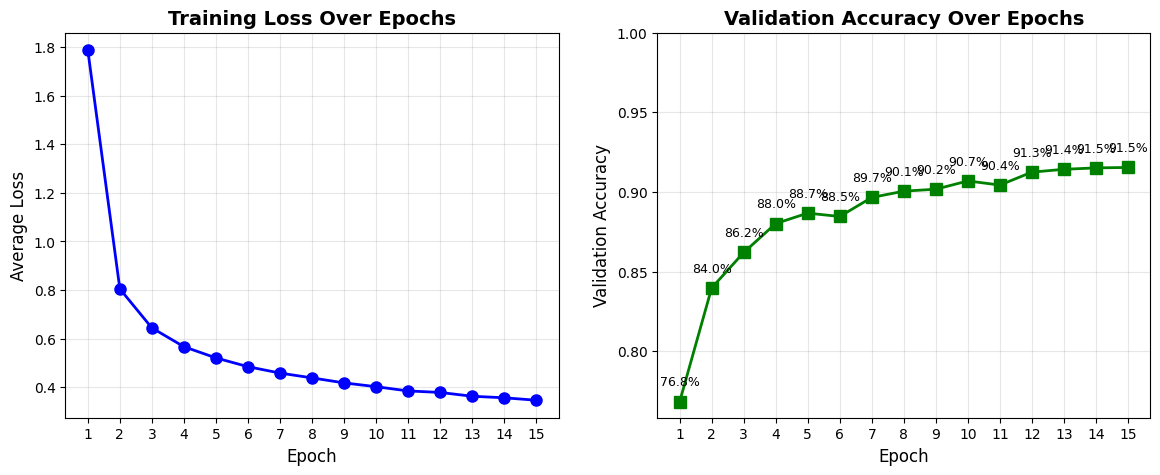

In [18]:
## visualize  accuracy and loss across 15 epochs

import matplotlib.pyplot as plt

# Plot 1: Average Loss vs Epoch
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
ax1.plot(range(1, len(losses) + 1), losses, marker='o', linewidth=2, markersize=8, color='blue')
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Average Loss', fontsize=12)
ax1.set_title('Training Loss Over Epochs', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.set_xticks(range(1, len(losses) + 1))

# Plot 2: Validation Accuracy vs Epoch
ax2.plot(range(1, len(accuracies) + 1), accuracies, marker='s', linewidth=2, markersize=8, color='green')
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Validation Accuracy', fontsize=12)
ax2.set_title('Validation Accuracy Over Epochs', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.set_xticks(range(1, len(accuracies) + 1))
ax2.set_ylim([min(accuracies) - 0.01, 1.0])

# Add value labels on accuracy plot
for epoch, acc in enumerate(accuracies, 1):
    ax2.text(epoch, acc + 0.01, f'{acc*100:.1f}%', ha='center', fontsize=9)

Much better, But will try one mroe thing, transformations, in order to add some more variety to the data to hopefully promote being able to find more distinguishing features of the different numbers in the images as well as a realistic scenario in which street signs may be captured at different angles

In [22]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.RandomRotation(10),      # small rotations
    transforms.RandomAffine(0, translate=(0.05, 0.05)),  # Small shifts
])

class Dataset_tr(torch.utils.data.Dataset):
  def __init__(self, X, y, transform=None):
      self.X = torch.FloatTensor(X)
      self.y = torch.LongTensor(y)
      self.transform = transform

  def __len__(self):
      return len(self.X)

  def __getitem__(self, idx):
    image = self.X[idx]

    # Only apply transform if it was provided
    if self.transform:
        image = self.transform(image)

    return image, self.y[idx]

#new dataset with rotations and shifts
dataset = Dataset_tr(X, y, transform=transform)

train, val = torch.utils.data.random_split(
    dataset, [int(0.8*len(dataset)), len(dataset) - int(0.8*len(dataset))])

train_loader = torch.utils.data.DataLoader(train, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val, batch_size=64, shuffle=False)

model = CNN_3_layer()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

accuracies = []
losses = []

for epoch in range(15):
  #training
  model.train()

  total_loss = 0


  pbar = tqdm(train_loader, desc=f"Epoch {epoch + 1}")
  for imgs, targets in pbar:
    optimizer.zero_grad()
    outputs = model(imgs)
    loss = loss_fn(outputs, targets)
    loss.backward()
    optimizer.step()
    pbar.set_postfix(loss=loss.item())
    total_loss += loss.item()

  avg_loss = total_loss / len(train_loader)
  print(f"Epoch {epoch+1}, Average Loss: {avg_loss:.4f}")

  model.eval()
  correct = 0
  total = 0
  with torch.no_grad():
    for images, labels in val_loader:
      outputs = model(images)
      _, predicted = torch.max(outputs, 1)
      correct += (predicted == labels).sum().item()
      total += labels.size(0)

  accuracy = correct / total
  accuracies.append(accuracy)
  losses.append(avg_loss)

  print(f"Epoch {epoch + 1} accuracy: {accuracy*100:.4f}%")


Epoch 1: 100%|██████████| 916/916 [02:13<00:00,  6.85it/s, loss=0.906]


Epoch 1, Average Loss: 1.8358
Epoch 1 accuracy: 69.3694%


Epoch 2: 100%|██████████| 916/916 [02:13<00:00,  6.85it/s, loss=0.745]


Epoch 2, Average Loss: 0.9458
Epoch 2 accuracy: 80.2280%


Epoch 3: 100%|██████████| 916/916 [02:15<00:00,  6.74it/s, loss=0.788]


Epoch 3, Average Loss: 0.7580
Epoch 3 accuracy: 82.7942%


Epoch 4: 100%|██████████| 916/916 [02:13<00:00,  6.86it/s, loss=0.648]


Epoch 4, Average Loss: 0.6782
Epoch 4 accuracy: 84.5345%


Epoch 5: 100%|██████████| 916/916 [02:11<00:00,  6.95it/s, loss=0.427]


Epoch 5, Average Loss: 0.6195
Epoch 5 accuracy: 85.7562%


Epoch 6: 100%|██████████| 916/916 [02:12<00:00,  6.91it/s, loss=0.775]


Epoch 6, Average Loss: 0.5814
Epoch 6 accuracy: 85.9473%


Epoch 7: 100%|██████████| 916/916 [02:11<00:00,  6.95it/s, loss=0.504]


Epoch 7, Average Loss: 0.5515
Epoch 7 accuracy: 87.4829%


Epoch 8: 100%|██████████| 916/916 [02:11<00:00,  6.96it/s, loss=0.537]


Epoch 8, Average Loss: 0.5318
Epoch 8 accuracy: 88.1040%


Epoch 9: 100%|██████████| 916/916 [02:10<00:00,  7.04it/s, loss=0.416]


Epoch 9, Average Loss: 0.5063
Epoch 9 accuracy: 88.6364%


Epoch 10: 100%|██████████| 916/916 [02:10<00:00,  7.00it/s, loss=0.44]


Epoch 10, Average Loss: 0.4886
Epoch 10 accuracy: 89.3393%


Epoch 11: 100%|██████████| 916/916 [02:14<00:00,  6.83it/s, loss=0.516]


Epoch 11, Average Loss: 0.4734
Epoch 11 accuracy: 89.5646%


Epoch 12: 100%|██████████| 916/916 [02:13<00:00,  6.87it/s, loss=0.295]


Epoch 12, Average Loss: 0.4612
Epoch 12 accuracy: 89.6806%


Epoch 13: 100%|██████████| 916/916 [02:11<00:00,  6.94it/s, loss=0.451]


Epoch 13, Average Loss: 0.4509
Epoch 13 accuracy: 89.5168%


Epoch 14: 100%|██████████| 916/916 [02:10<00:00,  7.00it/s, loss=0.415]


Epoch 14, Average Loss: 0.4446
Epoch 14 accuracy: 89.9263%


Epoch 15: 100%|██████████| 916/916 [02:10<00:00,  7.01it/s, loss=0.703]


Epoch 15, Average Loss: 0.4392
Epoch 15 accuracy: 90.4245%


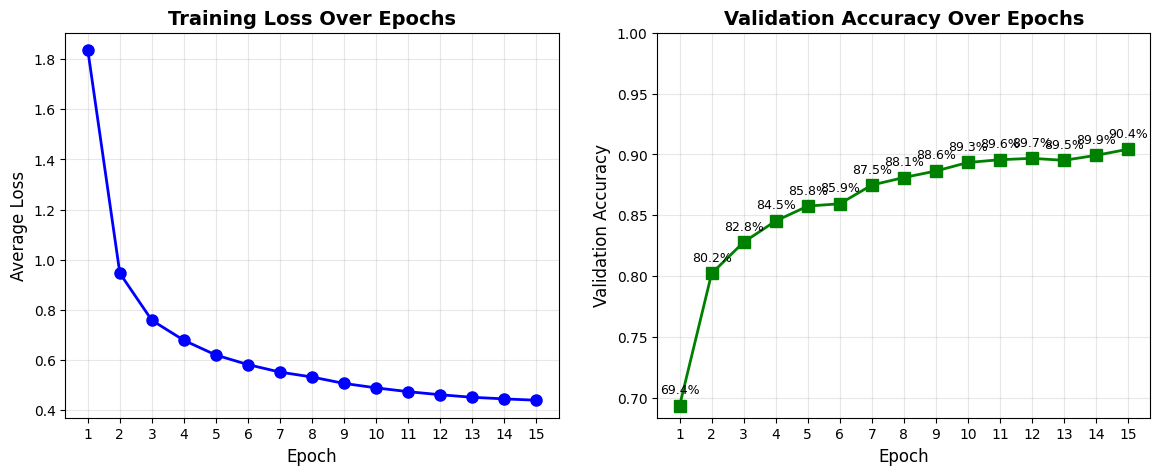

In [23]:
## visualize  accuracy and loss across 15 epochs

import matplotlib.pyplot as plt

# Plot 1: Average Loss vs Epoch
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
ax1.plot(range(1, len(losses) + 1), losses, marker='o', linewidth=2, markersize=8, color='blue')
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Average Loss', fontsize=12)
ax1.set_title('Training Loss Over Epochs', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.set_xticks(range(1, len(losses) + 1))

# Plot 2: Validation Accuracy vs Epoch
ax2.plot(range(1, len(accuracies) + 1), accuracies, marker='s', linewidth=2, markersize=8, color='green')
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Validation Accuracy', fontsize=12)
ax2.set_title('Validation Accuracy Over Epochs', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.set_xticks(range(1, len(accuracies) + 1))
ax2.set_ylim([min(accuracies) - 0.01, 1.0])

# Add value labels on accuracy plot
for epoch, acc in enumerate(accuracies, 1):
    ax2.text(epoch, acc + 0.01, f'{acc*100:.1f}%', ha='center', fontsize=9)